# 🧪 Mini P-Value Tutorial with Simulation
This notebook is a dive into **p-values**, using simulations and intuitive visuals to demystify the concept.
I'll build up from scratch, using a practical problem: **How do we decide if a set of numbers could have come from a Uniform[0,1] distribution?**

I will cover:
- What a p-value really means
- How simulation helps estimate p-values
- How to apply this logic beyond uniform tests (to normal, beta, etc.)

 🧪**But first, Hypothesis Testing — A Quick Recap**

🎯 Set up two competing ideas

**Null hypothesis (H₀):
The “default” assumption — nothing interesting is happening.**

Example: The numbers come from a uniform distribution.

**Alternative hypothesis (H₁):**
    
The thing you’re testing for — something is different.

Example: The numbers are not uniformly distributed.

**?** Ask — how extreme is your result under H₀?
This is where the **p-value** comes in. It helps you decide whether your observed result is “normal” or “suspicious” under the null.

## 🎯So, What is a P-value, Really?

A p-value is a way of asking:

“If my null hypothesis were true, how surprising would this result be?”

**Important:** A p-value is NOT:
- The probability that the null hypothesis is true
- A proof of non-randomness

It’s simply a way to measure how *surprising* your observation is under a specific assumption. 

A small p-value (like 0.01 or 0.03) means:
“This result is rare if the null is true.” → → Maybe the null is wrong.

A large p-value (like 0.6 or 0.8) means:
“This result is totally normal if the null is true.” → → No reason to doubt the null.

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(seed=42)

## 🎲 Step 1: Our Toy Question — Is this data Uniformly Distributed?
Let’s simulate a small dataset and test whether it could plausibly come from a Uniform[0,1] distribution.

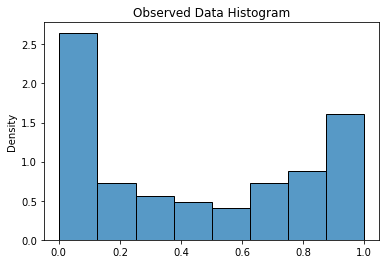

In [5]:
# Observed dataset
x = rng.beta(0.5, 0.5, size=100)  # deliberately not uniform
sns.histplot(x=x, stat='density')
plt.title('Observed Data Histogram')
plt.show()

## 🧪 Step 2: Test Statistic = Mean
We simulate many datasets from Uniform[0,1] and calculate their means.
Then we compare our observed mean to this simulated distribution.

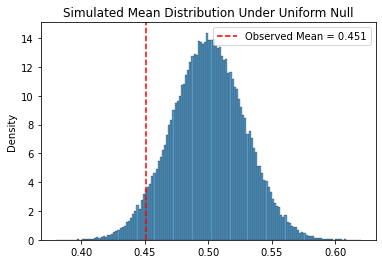

P-value (mean ≥ observed): 0.9534


In [6]:
n_reps = 100000
arr = rng.random((n_reps, len(x)))
sim_means = np.mean(arr, axis=1)

obs_mean = np.mean(x)
p_val_mean = np.mean(sim_means >= obs_mean)

sns.histplot(sim_means, stat='density')
plt.axvline(obs_mean, color='red', linestyle='--', label=f'Observed Mean = {obs_mean:.3f}')
plt.title('Simulated Mean Distribution Under Uniform Null')
plt.legend()
plt.show()
print(f'P-value (mean ≥ observed): {p_val_mean:.4f}')

## 🛠 Step 3: Generalize It — `test_rng()` Function
We now create a reusable function that can test **any test statistic** — mean, variance, skewness, etc.

In [7]:
def test_rng(x, func, rng_sampler, n_reps=100000):
    simulated = rng_sampler((n_reps, len(x)))
    obs_stat = func(x)
    sim_stats = np.apply_along_axis(func, axis=1, arr=simulated)
    return np.mean(sim_stats >= obs_stat), obs_stat

## 🔍 Step 4: Try Different Test Statistics
Let’s evaluate several test statistics and their p-values under the uniform assumption:

In [8]:
tests = {
    'mean': np.mean,
    'variance': np.var,
    'max': np.max,
    'median': np.median,
    'sum(x^3)': lambda x: np.sum(x**3),
    'sum(exp(-x))': lambda x: np.sum(np.exp(-x)),
    'median - mean': lambda x: np.median(x) - np.mean(x),
    'mean(abs(x - median))': lambda x: np.mean(np.abs(x - np.median(x)))
}

for name, func in tests.items():
    p, val = test_rng(x, func, rng.random)
    print(f'{name:25s} | stat = {val: .4f} | p-value = {p:.4f}')

mean                      | stat =  0.4513 | p-value = 0.9549
variance                  | stat =  0.1359 | p-value = 0.0000
max                       | stat =  0.9986 | p-value = 0.1269
median                    | stat =  0.4083 | p-value = 0.9682
sum(x^3)                  | stat =  28.4447 | p-value = 0.1126
sum(exp(-x))              | stat =  67.9812 | p-value = 0.0044
median - mean             | stat = -0.0430 | p-value = 0.9376
mean(abs(x - median))     | stat =  0.3387 | p-value = 0.0000


## 📈 Step 5: What if the True Distribution is Beta(9,9)?
Suppose we *know* our favorite distribution is Beta(9,9) — how does our test change?
Let’s simulate and test if our observed data fits *that* distribution.

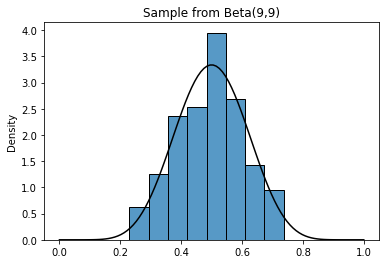

Testing Beta(9,9) sample under Uniform: p-value = 1.0000, observed variance = 0.0121


In [9]:
# Simulate data from beta(9,9)
y = rng.beta(9, 9, size=100)
sns.histplot(x=y, stat='density')
xs = np.linspace(0, 1, 100)
plt.plot(xs, stats.beta(9, 9).pdf(xs), color='black')
plt.title('Sample from Beta(9,9)')
plt.show()

p, val = test_rng(y, np.var, lambda size: rng.random(size))
print(f'Testing Beta(9,9) sample under Uniform: p-value = {p:.4f}, observed variance = {val:.4f}')

## ✅ Summary
- A p-value estimates how often you'd observe a test statistic as extreme as your data, under a null hypothesis.
- Simulation is a powerful, intuitive way to generate p-values when formulas are too complex or unknown.
- `test_rng()` makes this reusable across metrics and distributions.

🔬 **Applications**:
- A/B testing (mean difference)
- Outlier detection (max/min values)
- Quality control (variance thresholds)
- Scientific experiments (any custom test statistic)

## 🧠 Can We Blindly Trust P-values?

A **p-value** is not the final word — it’s a check metric.

---

### ✅ What You *Can* Trust a P-value To Do:
- Measure **how rare or extreme** your result is under the null
- Help you **flag unusual patterns** in the data
- Provide a consistent decision threshold (e.g., p < 0.05)

---

### ❌ What You *Shouldn’t* Expect from a P-value:
- It is **not** the probability that the null hypothesis is true
- It does **not** prove that your result is meaningful or important
- It is **not** immune to manipulation — p-hacking is real

### 💡 Use P-values Wisely:
- **Visualize** your data before and after testing
- Pair p-values with **effect sizes**, **confidence intervals**, and **domain knowledge**
- Don’t worship the 0.05 threshold — interpret it in context

> P-values don't give you truth — they give you a signal. It's your job to decide if it's noise or insight.


